# Brief Introduction of this project

This project is aming to use NLP technologies to explore the dataset and find out what we can do to get insights from it. I am going to focus on the predictive power here. But I showed a function to extract the feature importance. So it can also be use for analysis purpose. But I am not going to follow this part.

I have two topics here:
    1. Using 'title' and 'author' to predict if this context is over 18 or not;
    2. Based on the 'title' and 'author', find a best way to bucketize the 'up_votes' and predict each category.

The progress of analysis:

1. Exploritary Data Analysis and Topic Decision
2. Data Processing
    * Correlation Check('author')
    * Remove Punctuation
    * Words Tokenization
    * Words Stemming 
3. Modelling
    * Balance dataset
    * Enter Embeddings and Stop words Removing
    * Dimension Reduction
    * Model fitting and evaluating
    
I checked the length of each title and found the length is less than 66 and most of them are only 20. So I didn't plan to use word to vector method or RNN. For the first topic, I just used 'trunctedSVD' method for feature recuction and Logistic Regression to predict the 'ovre_18'. The reason why I used this method is because the sample size for positive cases is very small. To aviod overfitting, I chose to reduce the dimension first, then train a simple model. The result is wonderful, seeming like the words in the title and author somehow reflect the category information.

While the second topic is going to be more complicated. Because I need to bucketize the 'up_votes' and make the bucket reasonable and seperable. So I changed a little bit on the Modelling process.

3. Modelling  
    1. Balance dataset;  
    2. Set initial split point(binary split);  
    3. Enter Embeddings and Remove Stop words;  
    4. Select Model;  
    5. Change initial split and monitor the performance;  
    6. Fix initial split and tune model parameter;  
    7. Choose one category to detailly split and repeat (B)(D)(E).  

I used this method because the 'up_votes' is extremly right skewed and can't easily change it to normal. Besides, it's easy to find the sweet point with binary split. While you need to know that because we use a subset to create more categories, the performance of the sub_classification model is affected by the upper_classification model.
    

In [1]:
import pandas as pd
import nltk
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/gaozhiping/Desktop/Interviews/Eluvio/Eluvio_DS_Challenge.csv")

# 1. Exploritary Data Analysis and Topic Decision

In [3]:
data.head(5)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
data.describe()

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341585e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


In [5]:
# Checking data type and missing value
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null int64
date_created    509236 non-null object
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
category        509236 non-null object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


There is no missing value.

In [6]:
print ("Number of unique title is "+ str(len(data.title.unique())) + ".")
print ("Number of unique up_votes is "+ str(len(data.up_votes.unique())) + ".")
print ("Number of unique down_votes is "+ str(len(data.down_votes.unique())) + ".")
print ("Number of unique over_18 is "+ str(len(data.over_18.unique())) + ".")
print ("Number of unique author is "+ str(len(data.author.unique())) + ".")
print ("Number of unique category is "+ str(len(data.category.unique())) + ".")
print ("The earlest time_created is "+ str(data.time_created.min()) + ".")
print ("The latest time_created is "+ str(data.time_created.max()) + ".")
print ("The earlest date_created is "+ str(data.date_created.min()) + ".")
print ("The latest date_created is "+ str(data.date_created.max()) + ".")

Number of unique title is 500720.
Number of unique up_votes is 5782.
Number of unique down_votes is 1.
Number of unique over_18 is 2.
Number of unique author is 85838.
Number of unique category is 1.
The earlest time_created is 1201232046.
The latest time_created is 1479817346.
The earlest date_created is 2008-01-25.
The latest date_created is 2016-11-22.


As we can see, the down_votes and category have only one single value individually. So this value might not be useful for machine learning. Since this challenge is focusing on Natural Language Processing, the time_created and date_created are less valuable than the rest.

In [7]:
print ("The number of sample is %s, and the number of unique title is %s." % (data.title.count(), len(data.title.unique())))
print ("The number of duplicated sample is %s." % data.duplicated().sum())

The number of sample is 509236, and the number of unique title is 500720.
The number of duplicated sample is 6.


The number of unique title is less than the number of sample. However, we only have 6 duplicates. I would like to figure out the the reason behind this first.


In [8]:
unique_df = data.drop_duplicates().reset_index()
unique_df = unique_df.drop("index",axis=1)
unique_df.describe()

,time_created,up_votes,down_votes
count,5.092300e+05,509230.000000,509230.0
mean,1.380242e+09,112.237606,0.0
std,7.090268e+07,541.697730,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341587e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


In [9]:
# Look at the duplicates
title_count = unique_df.groupby("title").count().reset_index()
duplicates = title_count[title_count.category > 1].title

dupli_titles = pd.merge(left = duplicates, right = unique_df, how = "inner", on = "title")
print ("The number of duplicated titles is %s." % len(dupli_titles.title.unique()))
dupli_titles.head(6)

The number of duplicated titles is 7719.


,title,time_created,date_created,up_votes,down_votes,over_18,author,category
0,10 deaths on stranded Myanmar migrant boat,1431605634,2015-05-14,0,0,False,jackosan,worldnews
1,10 deaths on stranded Myanmar migrant boat,1431619643,2015-05-14,0,0,False,b0red,worldnews
2,"Al-Sadr calls off fighting amid airstrikes, c...",1206885758,2008-03-30,2,0,False,PaperLess,worldnews
3,"Al-Sadr calls off fighting amid airstrikes, c...",1206907231,2008-03-30,0,0,False,greenascanbe,worldnews
4,Allahu Akbar phrase hijacked by extremists a...,1463032122,2016-05-12,4,0,False,Neeraj10596,worldnews
5,Allahu Akbar phrase hijacked by extremists a...,1463036531,2016-05-12,0,0,False,Anddynee,worldnews


I found that the duplicated titles have similar created time but different up_votes and authors. If I have a chance to verify the data accuracy, it would be better. At this time, I am not going to use these samples to analyze and model. So I dirrect removed all of them.

In [88]:
# Deal with the duplicates
duplicates = pd.DataFrame(duplicates)
duplicates["dup"] = 1
dupli_titles_all = unique_df.merge(duplicates, how = "outer", left_on = "title", right_on = "title")
print ("The number of unique titles is %s." % len(dupli_titles_all[dupli_titles_all.dup != 1].title.unique()))

# Select the variables
clean_data = dupli_titles_all[dupli_titles_all.dup != 1][["title", "up_votes","over_18","author"]]
print ("The data has %s rows and %s columns" % (clean_data.shape[0], clean_data.shape[1]))
clean_data.over_18.value_counts()

The number of unique titles is 493001.
The data has 493001 rows and 4 columns


False    492684
True        317
Name: over_18, dtype: int64

We can see that the sample is seviously imbalanced, which could cause problems in classification model.`

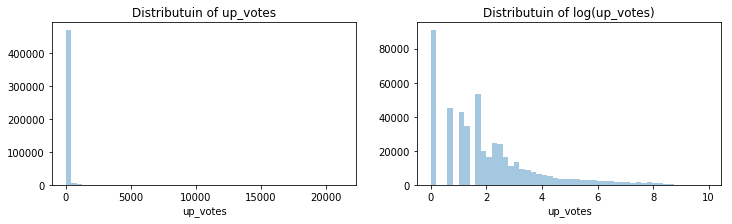

In [11]:
# Plot the distribution of up_votes
f, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.distplot(clean_data.up_votes, kde=False, ax = axes[0]).set_title("Distributuin of up_votes")

sns.distplot(np.log(clean_data.up_votes + 1), kde=False, ax=axes[1]).set_title("Distributuin of log(up_votes)")

plt.show()

The distribution of 'up_votes' seems like right skewed. When we add logorithm, it's still not normal distributed. If I want to predict up_votes, I might adress this problem by categorizing 'up_votes' such that we can assume it a classfication problem.

## 1.1 EDA summary

I found some insightful inforamtion about the dataset and here are several points:

* There is no missing value.
* The dataset has dupilicates and some authors have same title.
* The up_votes is extramely skewed, which can not be normalized by logrithm.

For addressing the duplicate, I cannot get to the data collector to understand the problem. While I found the data with duplicate is not very much. So I directly dropped them. 

For the 'up_votes', I found it not possible to treat it as a regression model. So I decided to buketize it for a multi-classification problem.

## 1.2 Topic decision
I am thinking about using title and author information to estimate 'over_18', which is a classfication model. Besides, I am thinking about using similar features to estimate 'up_votes',which is a multi-class model. Let's keep explorying the data to see if we can make them happened.

# 2. Data Processing
## 2.1 Author Correlation Check
Before conducting text mining, I would like to have a look at the author information. I think this information could somehow reflect the 'over_18' or 'up_votes'.

The number of different authors is 84192.
1561 authors have more than 40 titles.


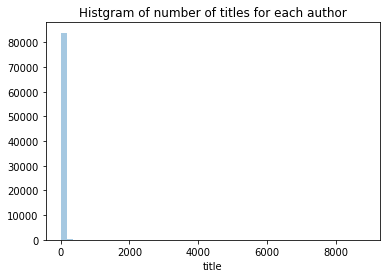

In [89]:
# Check the relationship between author and 'over_18'
print ("The number of different authors is %s." % len(clean_data.author.unique()))
author_distribution = clean_data.groupby("author").count()
print ("%s authors have more than 40 titles." % author_distribution[author_distribution.title > 40].count().title)
sns.distplot(author_distribution.title, kde=False).set_title("Histgram of number of titles for each author")
plt.show()

In [90]:
# The ratio of author that has both over_18 titles and non_over_18 titles
author_vs_18 = clean_data[["author","over_18"]].drop_duplicates().groupby("author").count()
print("The ratio of authors that have 2 kinds of titles is %.5f." % float(sum(author_vs_18.over_18 > 1)/author_vs_18.count()[0]))

The ratio of authors that have 2 kinds of titles is 0.00235.


This means almost every author has only one kind of title, either over_18 or not. Thus, I decided to use author as a feature for predicting 'over_18'.

## 2.2 Remove Punctuation

Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

In [91]:
# Remove punctuation of title
clean_data["title2"] = clean_data["title"].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
clean_data["title2"] = clean_data["title2"].str.lower()

## 2.3 Words Tokenization

In [92]:
## Tokenize
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_data["title2"] = clean_data["title2"].apply(tokenizer.tokenize)

In [93]:
clean_data.head()

,title,up_votes,over_18,author,title2
0,Scores killed in Pakistan clashes,3,False,polar,"[scores, killed, in, pakistan, clashes]"
1,Japan resumes refuelling mission,2,False,polar,"[japan, resumes, refuelling, mission]"
2,US presses Egypt on Gaza border,3,False,polar,"[us, presses, egypt, on, gaza, border]"
3,Jump-start economy: Give health care to all,1,False,fadi420,"[jump, start, economy, give, health, care, to,..."
4,Council of Europe bashes EU&UN terror blacklist,4,False,mhermans,"[council, of, europe, bashes, eu, un, terror, ..."


## 2.4 Words Stemming 

In [94]:
# Words Stemming
from nltk.stem import PorterStemmer

def stemming(x):
    ps = PorterStemmer()
    return [ps.stem(i) for i in x]


clean_data["title2"] = clean_data["title2"].apply(stemming)
clean_data.head()

,title,up_votes,over_18,author,title2
0,Scores killed in Pakistan clashes,3,False,polar,"[score, kill, in, pakistan, clash]"
1,Japan resumes refuelling mission,2,False,polar,"[japan, resum, refuel, mission]"
2,US presses Egypt on Gaza border,3,False,polar,"[us, press, egypt, on, gaza, border]"
3,Jump-start economy: Give health care to all,1,False,fadi420,"[jump, start, economi, give, health, care, to,..."
4,Council of Europe bashes EU&UN terror blacklist,4,False,mhermans,"[council, of, europ, bash, eu, un, terror, bla..."


In [95]:
# Transforme the response
clean_data["over_18"] = [1 if i is True else 0 for i in clean_data.over_18]

# Calculate the length of each tokenized title
clean_data["size_"] = clean_data.title2.apply(lambda x: len(x))

In [96]:
# Check the vocabularies in titles
all_words = [word for tokens in clean_data["title2"] for word in tokens]
VOCAB = sorted(list(set(all_words)))
author = sorted(list(set(clean_data.author)))
print("%s words total, with a vocabulary size of %s." % (len(all_words), len(VOCAB)))
print("The sample size is %s with %s different authors." % (clean_data.shape[0], len(author)))
print("Max sentence length is %s." % clean_data.size_.max())

7294384 words total, with a vocabulary size of 63707.
The sample size is 493001 with 84192 different authors.
Max sentence length is 66.


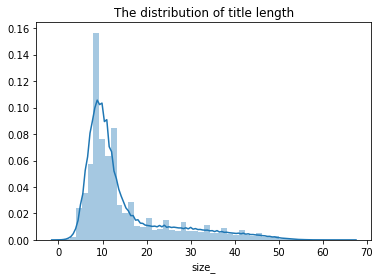

In [97]:
sns.distplot(clean_data.size_).set_title("The distribution of title length")
plt.show()

## 2.5 Balance the sample
Because the sample is imbalanced, I decided to upsample the minority and downsample the majority.

In [98]:
from sklearn.utils import resample

over18 = clean_data[clean_data.over_18  == 1]
under18 = clean_data[clean_data.over_18  == 0]

# Upsample to make it balanced
over18 = resample(over18, 
         replace=True,     # sample with replacement
         n_samples=2000)

# Downsample to make it balanced
under18 = resample(under18, 
          replace=False,    # sample without replacement
          n_samples=2000)    # to match minority class

Balanced_data = pd.concat([under18, over18])
Balanced_data.over_18.value_counts()

1    2000
0    2000
Name: over_18, dtype: int64

## 2.6 Enter Embeddings
I chose bag-of-words and TF-IDF as the embedding method to generate features.

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords


def cv(data):
    # Bag-of-words method to mine the data
    count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    
    emb = count_vectorizer.fit_transform(data)
    
    return emb, count_vectorizer


def tfidf(data):
    # TF-IDF method to mine the data
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    
    train = tfidf_vectorizer.fit_transform(data)
    
    return train, tfidf_vectorizer


def split_data(Balanced_data, label):
    # Return the splited training and testing data
    
    ## Join back the stemmed words
    Balanced_data["title3"] = Balanced_data.apply(lambda x : ' '.join(x["title2"]) + ' ' + x["author"], axis = 1)
    
    ## Bag-of-words
    X, count_vectorizer = cv(Balanced_data["title3"].tolist())
    y = Balanced_data[label].tolist()
    
    X_train_bw, X_test_bw, y_train_bw, y_test_bw = train_test_split(X, y, test_size=0.2, random_state=40)
    
    ## TF-IDF
    X, tfidf_vectorizer = tfidf(Balanced_data["title3"].tolist())
    y = Balanced_data[label].tolist()
    
    X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y, test_size=0.2, random_state=40)
    
    return [(X_train_bw, X_test_bw, y_train_bw, y_test_bw),(X_train_tf, X_test_tf, y_train_tf, y_test_tf)]

In [100]:
sample = split_data(Balanced_data, label = "over_18")
X_train_bw, X_test_bw, y_train_bw, y_test_bw = sample[0]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = sample[1]

# 3. Over_18 Classification Modelling
The first model I want to build is classification model aiming to predict 'over_18'.
## 3.1 Dimension Reduction
For dimension reducing, I used TruncatedSVD, which is designed for sparse metrics.

In [101]:
from sklearn.decomposition import TruncatedSVD

## Bag of word method
lsa = TruncatedSVD(n_components=250)
lsa.fit(X_train_bw)

X_train_svd_bw = lsa.transform(X_train_bw)
X_test_svd_bw = lsa.transform(X_test_bw)

## TF-idf method
lsa = TruncatedSVD(n_components=250)
lsa.fit(X_train_tf)

X_train_svd_tf = lsa.transform(X_train_tf)
X_test_svd_tf = lsa.transform(X_test_tf)

## 3.2 Logistic Regression
I would like to start with thie simplest one. if it doesn't perform well, I would try the more complicated ones.

In [102]:
from sklearn.linear_model import LogisticRegression

## Bag of words method
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         n_jobs=-1, random_state=40)
clf.fit(X_train_svd_bw, y_train_bw)
y_predicted_bw = clf.predict(X_test_svd_bw)

## TF-idf method
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         n_jobs=-1, random_state=40)
clf.fit(X_train_svd_tf, y_train_tf)
y_predicted_tf = clf.predict(X_test_svd_tf)

In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

## Bag of words method
accuracy, precision, recall, f1 = get_metrics(y_test_bw, y_predicted_bw)
print("The performance of Bag of word")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

## TF-idf method
accuracy, precision, recall, f1 = get_metrics(y_test_tf, y_predicted_tf)
print("The performance of TF-IDF")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

The performance of Bag of word
accuracy = 0.970, precision = 0.970, recall = 0.970, f1 = 0.970
The performance of TF-IDF
accuracy = 0.975, precision = 0.975, recall = 0.975, f1 = 0.975


The performance of Bag-of-words is very similar to TF-IDF. So I am not going to use bag-of-word here.

## 3.3 Model Inspection

In [104]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

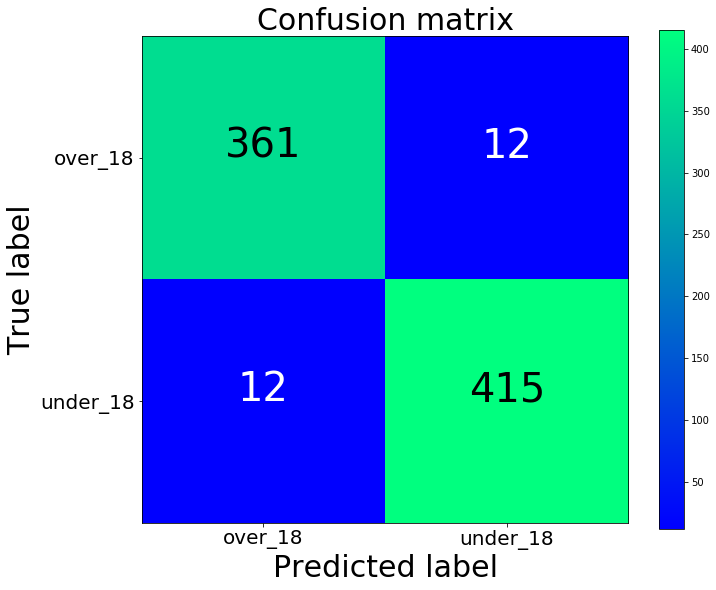

In [105]:
# Plot condusion matrix to visualize the performance
cm = confusion_matrix(y_test_bw, y_predicted_bw)
fig = plt.figure(figsize=(10, 8))
plot = plot_confusion_matrix(cm, classes=['over_18','under_18'], normalize=False, title='Confusion matrix')
plt.show()

## 3.4 Get feature importance

In [112]:
## Join back the stemmed words
Balanced_data["title3"] = Balanced_data.apply(lambda x : ' '.join(x["title2"]) + ' ' + x["author"], axis = 1)

X, count_vectorizer = cv(Balanced_data["title3"].tolist())
y = Balanced_data['over_18'].tolist()

X_train_bw, X_test_bw, y_train_bw, y_test_bw = train_test_split(X, y, test_size=0.2, random_state=40)

# Feature selection
clf_tr = RandomForestClassifier(n_estimators=120, max_depth=40, random_state=0)
clf_tr.fit(X_train_bw, y_train_bw)

y_predicted_bw = clf_tr.predict(X_test_bw)
accuracy, precision, recall, f1 = get_metrics(y_test_bw, y_predicted_bw)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# Feature importance dataframe
Feature = pd.DataFrame(count_vectorizer.get_feature_names(), columns = ["feature"])
Feature["importance"] = clf_tr.feature_importances_

important_fea = Feature.sort_values(by = "importance", ascending=False)
important_fea.head(10)

accuracy = 0.940, precision = 0.944, recall = 0.940, f1 = 0.940


,feature,importance
4607,nsfw,0.119510
7022,video,0.044511
4606,nsfl,0.025042
2838,graphic,0.020627
1800,dead,0.015285
5963,shot,0.014144
5176,protest,0.013533
2345,execut,0.012809
6695,topless,0.012260
3223,imag,0.011631


## 3.5 Summary
As we can see, the model performed very well. Of Couse, it could be the limitation of sample size(4000) compared with the large size of features(250). Also, we can go back to see the vocabularies that contribute to the model. Of course, we can choose some other feature selection method so that we can go check the word importance. 

# 4. Up_votes Classification Modelling
Right now, I am going to see if title and author can be used for up_votes prediction. As I explored before, the 'up_votes' is not normal distributed. And we can't solve it with poison regression. So I decided to buketize the 'up_votes' to create a classification problem.
## 4.1 up_votes categorizing
It's not easy to find the best place to seperate the 'up_votes', so that the title and author information can better represent the 'up_votes'. So I started with inital binary seperating. Here are my steps:
    1. With inital binary seperating, I used the previous logistic regression to generate a model; 
    2. I changed the seperating point, in order to achive a relative higher model performance on the fixed model setting;
    3. With fixed seperating point, I improved the model. I chose random forest for feature selection, then implement the selected feature to train the logistic regression, which achieved a better performance.

In [118]:
# Categorize the up_votes
def vote_cate(x):
    if x > 1000: return 1
    else: return 2

clean_data["up_votes_cat"] = clean_data.up_votes.apply(vote_cate)
clean_data.up_votes_cat.value_counts()

2    478609
1     14392
Name: up_votes_cat, dtype: int64

## 4.2 Balance the dataset
Before training the model, we need to balance the dataset. I upsampled the minority and downsampled the majority considering the 'sample size' vs 'feature number'.

In [119]:
# Balance the sample
up_1 = clean_data[clean_data.up_votes_cat  == 1]
up_2 = clean_data[clean_data.up_votes_cat  == 2]

# Downsample to make it balanced
up_2 = resample(up_2, 
          replace=False,    # sample without replacement
          n_samples=90000)    # to match minority class

# upsample to make it balanced
up_1 = resample(up_1, 
          replace=True,    # sample without replacement
          n_samples=90000)    # to match minority class

Balanced_data = pd.concat([up_1, up_2])
Balanced_data.up_votes_cat.value_counts()

2    90000
1    90000
Name: up_votes_cat, dtype: int64

## 4.3 Enter Embeddings

In [120]:
Balanced_data.head()

,title,up_votes,over_18,author,title2,size_,up_votes_cat
246396,Ukraine: One of kidnapped protestors was found...,2829,0,uncleban,"[ukrain, one, of, kidnap, protestor, wa, found...",13,1
473449,Six gay men in Ivory Coast were abused and for...,5203,0,DoremusJessup,"[six, gay, men, in, ivori, coast, were, abus, ...",34,1
506087,"New Delhi s air is now so toxic, schools are c...",1946,0,YoSoyUnPayaso,"[new, delhi, s, air, is, now, so, toxic, schoo...",15,1
407495,"Lockheed Martin, Boeing rally around Saudi Ara...",3864,0,underweargnome04,"[lockhe, martin, boe, ralli, around, saudi, ar...",11,1
105889,Bill would make wearing masks during riots a c...,1730,0,galt1776,"[bill, would, make, wear, mask, dure, riot, a,...",9,1


In [121]:
# Split the dataset to training and testing sets
sample = split_data(Balanced_data, label="up_votes_cat")
X_train_bw, X_test_bw, y_train_bw, y_test_bw = sample[0]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = sample[1]

## 4.4 Select the Embeddings
Here I used the logistic regression for selecting embedding method.
### 4.4.1 Dimension Reduction

In [43]:
## Bag of word method
lsa = TruncatedSVD(n_components=150)
lsa.fit(X_train_bw)

X_train_svd_bw = lsa.transform(X_train_bw)
X_test_svd_bw = lsa.transform(X_test_bw)

## TF-idf method
lsa = TruncatedSVD(n_components=150)
lsa.fit(X_train_tf)

X_train_svd_tf = lsa.transform(X_train_tf)
X_test_svd_tf = lsa.transform(X_test_tf)

### 4.4.2 Logistic Regression

In [71]:
## Bag of words method
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_svd_bw, y_train_bw)
y_predicted_bw = clf.predict(X_test_svd_bw)

## TF-idf method
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_svd_tf, y_train_tf)
y_predicted_tf = clf.predict(X_test_svd_tf)

### 4.4.3 Model performance

In [72]:
## Bag of words method
accuracy, precision, recall, f1 = get_metrics(y_test_bw, y_predicted_bw)
print("The performance of Bag of word")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

## TF-idf method
accuracy, precision, recall, f1 = get_metrics(y_test_tf, y_predicted_tf)
print("The performance of TF-IDF")
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

The performance of Bag of word
accuracy = 0.932, precision = 0.998, recall = 0.932, f1 = 0.963
The performance of TF-IDF
accuracy = 0.932, precision = 0.998, recall = 0.932, f1 = 0.963


TF-IDF performs slightly better here. But we neet to choose a better parameter or a better model.

## 4.5 Choose split point
Because I found the performance of logistic regresion wasn't very good. I was thinking that there might be some noise and planing to use random forest to eliminate some useless words. 

With some tests, I confirm that feature selection with random forest is much better. So I used the random forest as the model to select the best split point.

In [114]:
from sklearn.ensemble import RandomForestClassifier

def find_sweet_point(first, second):
    # Categorize the up_votes
    def vote_cate(x):
        if x > second: return 1
        elif x <= first: return 3
        else: return 2
    
    clean_data["up_votes_cat"] = clean_data.up_votes.apply(vote_cate)
    print(clean_data.up_votes_cat.value_counts())
    
    # Balance the sample
    up_3 = clean_data[clean_data.up_votes_cat  == 3]
    up_2 = clean_data[clean_data.up_votes_cat  == 2]
    
    # Downsample to make it balanced
    up_3 = resample(up_3, 
              replace=False,    # sample without replacement
              n_samples=1700)    # to match minority class
    
    # upsample to make it balanced
    up_2 = resample(up_2, 
              replace=True,    # sample without replacement
              n_samples=1700)    # to match minority class
    
    Balanced_data = pd.concat([up_2, up_3])
    Balanced_data.up_votes_cat.value_counts()
    
    # Join back the stemmed words
    Balanced_data["title3"] = Balanced_data.apply(lambda x : ' '.join(x["title2"]) + ' ' + x["author"], axis = 1)
    
    # TF-IDF
    X, tfidf_vectorizer = tfidf(Balanced_data["title3"].tolist())
    y = Balanced_data["up_votes_cat"].tolist()
    
    X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y, test_size=0.2, random_state=40)
    
    # Train the model 
    clf_tr = RandomForestClassifier(n_estimators=120, max_depth=40, random_state=0)
    clf_tr.fit(X_train_tf, y_train_tf)
    y_predicted_tf = clf_tr.predict(X_test_tf)
    
    print ("The point you have is %s" % first)
    accuracy, precision, recall, f1 = get_metrics(y_test_tf, y_predicted_tf)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print("-"*40)

In [115]:
def training_model(Balanced_data, num_features, classes=['2', '3']):
    # Join back the stemmed words
    Balanced_data["title3"] = Balanced_data.apply(lambda x : ' '.join(x["title2"]) + ' ' + x["author"], axis = 1)
    
    # TF-IDF
    X, tfidf_vectorizer = tfidf(Balanced_data["title3"].tolist())
    y = Balanced_data["up_votes_cat"].tolist()
    
    X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y, test_size=0.2, random_state=40)
    Features = tfidf_vectorizer.get_feature_names()
    
    # Feature selection
    clf_tr = RandomForestClassifier(n_estimators=120, max_depth=40, random_state=0)
    clf_tr.fit(X_train_tf, y_train_tf)

    Feature_dict = {i:v for i,v in zip(Features,range(len(Features)))}
    
    # Feature importance dataframe
    Feature = pd.DataFrame(Features, columns = ["feature"])
    Feature["importance"] = clf_tr.feature_importances_
    
    important_fea = Feature.sort_values(by = "importance", ascending=False).iloc[:num_features, 0]   # Choose the top 64000 features
    index = [Feature_dict[i] for i in important_fea]
    
    # Train
    clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                            multi_class='multinomial', n_jobs=-1, random_state=40)
    print(clf)
    clf.fit(X_train_tf[:,index], y_train_tf)
    y_predicted_tf = clf.predict(X_test_tf[:,index])
    accuracy, precision, recall, f1 = get_metrics(y_test_tf, y_predicted_tf)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    cm = confusion_matrix(y_test_tf, y_predicted_tf)
    fig = plt.figure(figsize=(10, 8))
    plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix')
    plt.show()
    return Feature.sort_values(by = "importance", ascending=False)

### 4.5.1 Choose the first split point

In [122]:
# Finding the sweet point
a_list = [100, 300, 600, 800, 1000, 1200, 2000]
for i in a_list:
    find_sweet_point(i, float("inf"))

3    443994
2     49007
Name: up_votes_cat, dtype: int64
The point you have is 100
accuracy = 0.632, precision = 0.633, recall = 0.632, f1 = 0.631
----------------------------------------
3    463314
2     29687
Name: up_votes_cat, dtype: int64
The point you have is 300
accuracy = 0.634, precision = 0.636, recall = 0.634, f1 = 0.631
----------------------------------------
3    473026
2     19975
Name: up_votes_cat, dtype: int64
The point you have is 600
accuracy = 0.659, precision = 0.662, recall = 0.659, f1 = 0.656
----------------------------------------
3    476373
2     16628
Name: up_votes_cat, dtype: int64
The point you have is 800
accuracy = 0.612, precision = 0.612, recall = 0.612, f1 = 0.611
----------------------------------------
3    478609
2     14392
Name: up_votes_cat, dtype: int64
The point you have is 1000
accuracy = 0.654, precision = 0.655, recall = 0.654, f1 = 0.653
----------------------------------------
3    480296
2     12705
Name: up_votes_cat, dtype: int64
Th

Considering about the goal of categorizing 'up_votes', I decided to choose 1000 as the first sweet point to split the dataset. Because it can group a relatively large titles and keep a high accuracy.

### 4.5.2 Train the model with selected features

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.900, precision = 0.905, recall = 0.900, f1 = 0.899


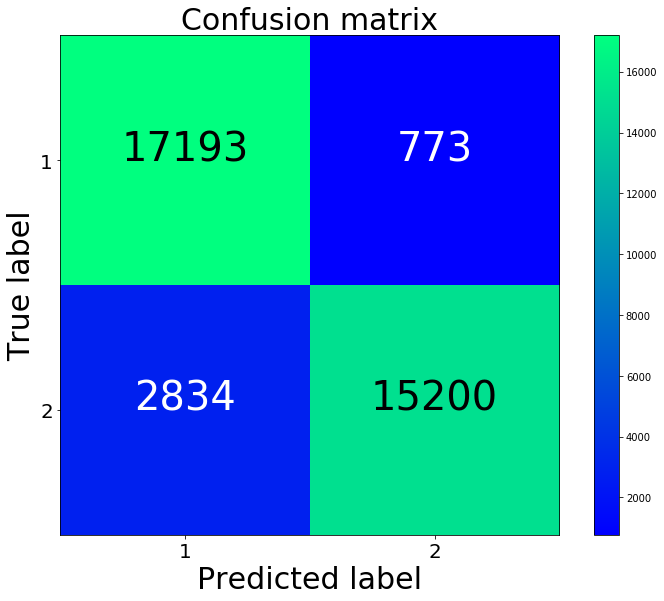

,feature,importance
34679,maxwellhill,0.023662
23341,ha,0.015872
50821,snowden,0.012764
27137,iran,0.010107
39451,nsa,0.009760
60861,year,0.009267
1,000,0.009252
4744,anutensil,0.008016
14420,davidreiss666,0.007626
25963,igeldard,0.006946


In [123]:
Important_fea = training_model(Balanced_data, num_features = 62000, classes=['1', '2'])
Important_fea.head(10)

### 4.5.3 Summay 1
Right now, we can split the dataset by 'up_vote > 1000' and 'up_votes <= 1000'. The overall accuracy is 0.900, which is alrealy very good. We can also go back to 'Feature' to have a look at the feature importance(Important_fea) and get a better idea about the words that are captured. While these two category is not even, we have only 3% titles having up_votes larger than 1000. So I want to be more specific on the rest 97%.

### 4.5.4 Split the 'up_votes <= 1000

In [78]:
# Finding the sweet point
a_list = [150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
for i in a_list:
    find_sweet_point(i, 1000)

3    451615
2     26994
1     14392
Name: up_votes_cat, dtype: int64
The point you have is 150
accuracy = 0.588, precision = 0.589, recall = 0.588, f1 = 0.585
----------------------------------------
3    452780
2     25829
1     14392
Name: up_votes_cat, dtype: int64
The point you have is 160
accuracy = 0.563, precision = 0.563, recall = 0.563, f1 = 0.563
----------------------------------------
3    453806
2     24803
1     14392
Name: up_votes_cat, dtype: int64
The point you have is 170
accuracy = 0.601, precision = 0.603, recall = 0.601, f1 = 0.598
----------------------------------------
3    454866
2     23743
1     14392
Name: up_votes_cat, dtype: int64
The point you have is 180
accuracy = 0.610, precision = 0.611, recall = 0.610, f1 = 0.608
----------------------------------------
3    455812
2     22797
1     14392
Name: up_votes_cat, dtype: int64
The point you have is 190
accuracy = 0.616, precision = 0.617, recall = 0.616, f1 = 0.615
----------------------------------------


LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.853, precision = 0.858, recall = 0.853, f1 = 0.852


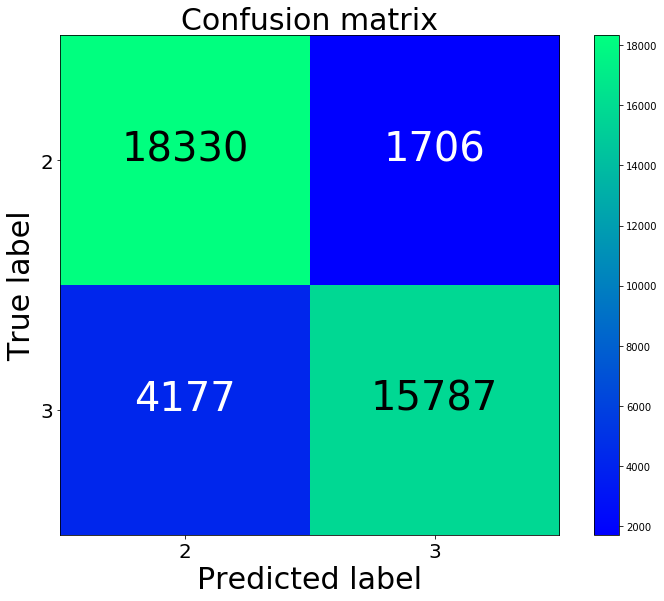

36848    maxwellhill
64900           year
24788             ha
62858             wa
5063       anutensil
27639       igeldard
1                000
29012            isi
28830           iran
57168           talk
Name: feature, dtype: object

In [79]:
a = 240

def vote_cate(x):
        if x > 1000: return 1
        elif x <= a: return 3
        else: return 2
    
# add new label 
clean_data["up_votes_cat"] = clean_data.up_votes.apply(vote_cate)
clean_data.up_votes_cat.value_counts()

#3 :   459703
#2 :    18906
#1 :    14392

# Balance the sample
up_3 = clean_data[clean_data.up_votes_cat  == 3]
up_2 = clean_data[clean_data.up_votes_cat  == 2]

# Downsample to make it balanced
up_3 = resample(up_3, 
          replace=False,    # sample without replacement
          n_samples=100000)    # to match minority class

# upsample to make it balanced
up_2 = resample(up_2, 
          replace=True,    # sample without replacement
          n_samples=100000)    # to match minority class

Balanced_data = pd.concat([up_2, up_3])
Balanced_data.up_votes_cat.value_counts()

Important_fea = training_model(Balanced_data, num_features = 62000, classes=['2', '3'])
Important_fea.head(10)

### 4.5.5 Summay 2
Right now, we can split 97% of dataset by '250 <= up_votes <= 1000' and 'up_votes < 250'. The overall accuracy is 0.853, which is also very good. We can also go back to 'Feature' to have a look at the feature importance(Important_fea) and get a better idea about the words that are captured. While these two category is still not even, but till now, we can get 6.6% titles predicted. So I want to be more specific on the rest 93.4%.

### 4.5.6 Split the 'up_votes <= 240

In [80]:
a_list = [2, 3, 4 , 5, 6, 8, 10, 15, 30, 40]
for i in a_list:
    find_sweet_point(i, 240)

2    281176
3    178527
1     33298
Name: up_votes_cat, dtype: int64
The point you have is 2
accuracy = 0.529, precision = 0.529, recall = 0.529, f1 = 0.528
----------------------------------------
2    246327
3    213376
1     33298
Name: up_votes_cat, dtype: int64
The point you have is 3
accuracy = 0.547, precision = 0.547, recall = 0.547, f1 = 0.543
----------------------------------------
3    242285
2    217418
1     33298
Name: up_votes_cat, dtype: int64
The point you have is 4
accuracy = 0.551, precision = 0.552, recall = 0.551, f1 = 0.548
----------------------------------------
3    266852
2    192851
1     33298
Name: up_votes_cat, dtype: int64
The point you have is 5
accuracy = 0.546, precision = 0.545, recall = 0.546, f1 = 0.545
----------------------------------------
3    286980
2    172723
1     33298
Name: up_votes_cat, dtype: int64
The point you have is 6
accuracy = 0.528, precision = 0.528, recall = 0.528, f1 = 0.527
----------------------------------------
3    31678

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.796, precision = 0.816, recall = 0.796, f1 = 0.800


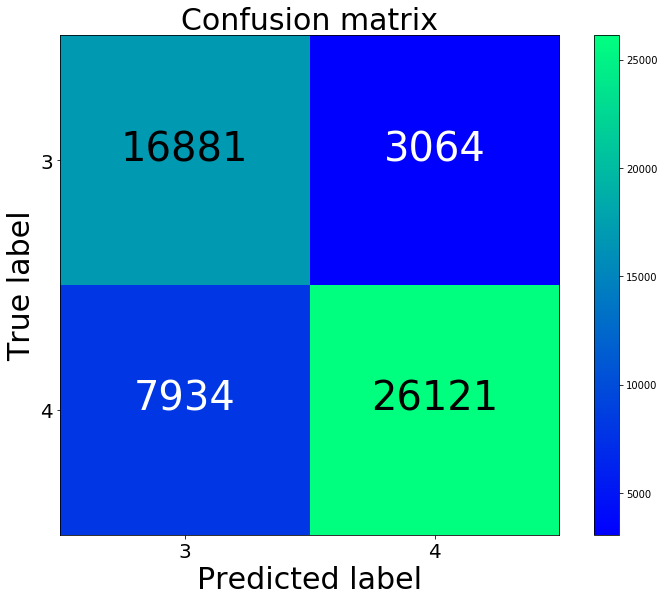

30191               ha
44963      maxwellhill
79010             year
18831    davidreiss666
6308         anutensil
76478               wa
1                  000
8684               ban
69223            syria
14979            china
Name: feature, dtype: object

In [81]:
def vote_cate(x):
        if x > 1000: return 1
        elif x > 240: return 2
        elif x > 6: return 3
        else: return 4
    
# add new label 
clean_data["up_votes_cat"] = clean_data.up_votes.apply(vote_cate)
clean_data.up_votes_cat.value_counts()

#3 :   460301
#2 :    18308
#1 :    14392

# Balance the sample
up_3 = clean_data[clean_data.up_votes_cat  == 3]
up_4 = clean_data[clean_data.up_votes_cat  == 4]

# Downsample to make it balanced
up_3 = resample(up_3, 
          replace=False,    # sample without replacement
          n_samples=170000)    # to match minority class

# upsample to make it balanced
up_4 = resample(up_4, 
          replace=True,    # sample without replacement
          n_samples=170000)    # to match minority class

Balanced_data = pd.concat([up_2, up_3])
Balanced_data.up_votes_cat.value_counts()

Important_fea = training_model(Balanced_data, num_features = 58000, classes=['3', '4'])
Important_fea.head(10)

### 4.5.7 Summay 3
Right now, we can split 97% of dataset by '6 <= up_votes <= 250' and 'up_votes < 6'. The overall accuracy is 0.796, which is also very good. We can also go back to 'Important_fea' to have a look at the feature importance and get a better idea about the words that are captured. While these two category is even now, so I am planing to stop here. Of course I can keep going to test if I can split it more specificly. But I think it's enough right now.

* 1: up_votes > 1000                 (14392)
* 2: 240 <= up_votes <= 1000         (18308)
* 3: 6 <= up_votes < 240            (172723)
* 4: up_votes < 6                   (286980)